In [84]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import os 
import time

(32, 48)
Saliency map generation duration: 0.11s


/tmp/ipykernel_66090/2397753041.py:29: RuntimeWarning: invalid value encountered in divide
  b= np.where(cond, b/i,  0.)
/tmp/ipykernel_66090/2397753041.py:30: RuntimeWarning: invalid value encountered in divide
  g= np.where(cond, g/i,  0.)
/tmp/ipykernel_66090/2397753041.py:31: RuntimeWarning: invalid value encountered in divide
  r= np.where(cond, r/i,  0.)


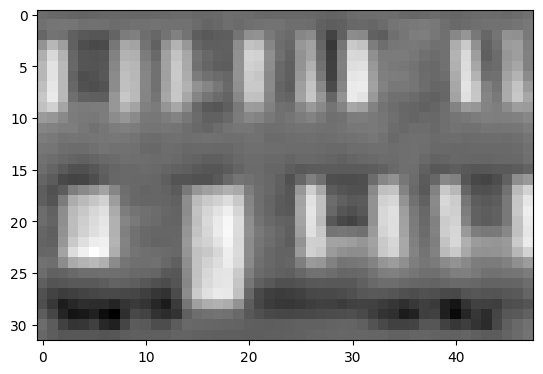

In [ ]:
class saliency_map():
    def __init__(self):
        pass

    def read_image(self, path_to_image):
        #read image method
        assert path_to_image is not None, "file could not be read, check with os.path.exists()"
        return cv2.imread(path_to_image)
      
    

    def get_rgb_channels(self, image):
        """
            Input: rgb image
            Output: r, g, b channels images
        """
        if isinstance(image, str):
            img = self.read_image(image)
        else:
            img = image
        i = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64)#self.get_intensity_image(image)
        b, g, r = cv2.split(img)
        
    
        max_value = np.amax(img)

        #normalize colors 
        cond = i>0.1*max_value
        b= np.where(cond, b/i,  0.)
        g= np.where(cond, g/i,  0.)
        r= np.where(cond, r/i,  0.)
      
        
        return r, g, b
    

    def get_intensity_image(self, image):
        """
            Input: rgb image
            Output: intensity image: I = (r+g+b)/3
        """
        if isinstance(image, str):
            img = self.read_image(image)
        else:
            img = image
        I = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        return I.astype(np.float64)
    

    def get_broadly_tuned_color_channels_images(self, image):
        """
            Input: Image
            Output: Broadly tuned color channel images: R, G, B

        """
        r, g, b = self.get_rgb_channels(image)
    
        
        R = r - (g + b) / 2
        G = g - (r + b) / 2
        B = b - (r + g) / 2
        Y = (r + g) / 2 - np.abs(r - g) / 2 - b


        R[R < 0] = 0
        G[G < 0] = 0
        B[B < 0] = 0
        Y[Y < 0] = 0
        return [R, G, B, Y]

    #One can play with the method parameters
    def create_gabor_kernels(self):
        orientations = [0, np.pi/4, 2*np.pi/4, 3*np.pi/4]
        return [cv2.getGaborKernel((5, 5), 5, theta, 10, 1) for theta in orientations]


    def gaussian_pyramid(self,image, levels=9):
        pyramid = []

        for _ in range(levels):    
            image = cv2.pyrDown(image)  
            pyramid.append(image)
        return pyramid

    
    def gabor_pyramids(self, gabor_kernels, intensity_pyramids):
        """
        """
        orientations = ["0", "45", "90", "135"]
        return {
            ori: [cv2.filter2D(pyr, cv2.CV_64F, kernel) for pyr in intensity_pyramids]
            for ori, kernel in zip(orientations, gabor_kernels)
        }


    def compute_all_gaussian_pyramids(self, path_to_image) :
        """
        """

        intensity = self.get_intensity_image(path_to_image)
        colors = self.get_broadly_tuned_color_channels_images(path_to_image)

        #intensity pyramids
        intensity_pyr = self.gaussian_pyramid(intensity)

        #colors gaussian pyramids
        colors_pyr = [[self.gaussian_pyramid(i)] for i in colors]


        gaussian_pyr = {
            "intensity": intensity_pyr,
            "color": colors_pyr,
            "orientation": self.gabor_pyramids(self.create_gabor_kernels(),intensity_pyr)
        }

        return gaussian_pyr


    def normalize_image(self, image, end=0.0, begin=255.):
        return cv2.normalize(image, None, begin, end, cv2.NORM_MINMAX).astype(np.float64)
        

    def center_surround_difference(self,pyramid):
        """     
        Across scale difference between coarse and finer scales   
        """
        differences = []
        for c in range(2,5):
            for s in [3,4]:
            # Interpolate the smaller image to match the size of the larger one
                larger = pyramid[c]
                smaller = cv2.resize(pyramid[c+s], (larger.shape[1], larger.shape[0]), interpolation=cv2.INTER_LINEAR)
            
                # Perform subtraction
                difference = cv2.subtract(larger, smaller)  # Ensure non-negative values
                differences.append(difference.astype(np.float64))
        return differences

    
    def feature_maps(self, path_to_image):
        """
        """
        #Intensity feature maps
        gaussian_pyr = self.compute_all_gaussian_pyramids(path_to_image)

        intensity_features = self.center_surround_difference(gaussian_pyr['intensity'])

        orientations_features = {
            ori: self.center_surround_difference(gaussian_pyr["orientation"][ori])
            for ori in gaussian_pyr["orientation"]
        }

        #colors orientation: 

        R, G, B, Y = gaussian_pyr["color"]
        
        

        RG_features = []
        #print(len(R[0][2]), len(G[0][2]),len(B[0]), len(Y[0]))
        for c in range(2,5):
            for s in [3,4]:
                #print(R[2])
            # Interpolate the smaller image to match the size of the larger one
                larger = cv2.subtract(R[0][c],G[0][c])
                smaller = cv2.subtract(R[0][c+s],G[0][c+s])
                smaller = cv2.resize(smaller, (larger.shape[1], larger.shape[0]), interpolation=cv2.INTER_LINEAR)
            
                # Perform subtraction
                difference = cv2.subtract(larger, smaller)  
                RG_features.append(difference)
        
        GY_features = []
        for c in range(2,5):
            for s in [3,4]:
            # Interpolate the smaller image to match the size of the larger one
                larger = cv2.subtract(B[0][c],Y[0][c])
                smaller = cv2.subtract(B[0][c+s], Y[0][c+s])
                smaller = cv2.resize(smaller, (larger.shape[1], larger.shape[0]), interpolation=cv2.INTER_LINEAR)
            
                # Perform subtraction
                difference = cv2.subtract(larger, smaller)  
                GY_features.append(difference)

        # all features maps
        features_maps = {
            "intensity": intensity_features,
            "colors": [RG_features, GY_features],
            "orientation": orientations_features
        }

        return features_maps


    def normalization_operator(self, feature_map):
        feature_map = self.normalize_image(feature_map, 0., 1.)  
        g_max = np.amax(feature_map) 
        maxs = []
        for x in range(1, len(feature_map) - 1):
            for y in range(1, len(feature_map[0]) - 1):
                pix = feature_map[x][y]
                
                if pix != g_max and pix > feature_map[x - 1][y] and pix > feature_map[x + 1][y] and pix > feature_map[x][y - 1] and pix > feature_map[x][y + 1]:
                    maxs.append(pix)

        if maxs:
            feature_map *= (g_max - (np.sum(maxs) / np.float64(len(maxs))))**2
        return feature_map
     

    def across_scale_addition(self, feature_map, target_scale=3):
        """
        """
        target_image = feature_map[target_scale]
        target_size = (target_image.shape[1], target_image.shape[0])


        addition_image = np.zeros_like(target_image, dtype=np.float64)

        # Resize each level to the target size and add it point-by-point
        for level in feature_map:
            resized = cv2.resize(self.normalization_operator(level), target_size, interpolation=cv2.INTER_LINEAR)
            addition_image += resized


        return addition_image

    

    def conspicuity_maps(self, path_to_image):
        """
        """
        features_maps = self.feature_maps(path_to_image)

        intensity_conspicuity = self.across_scale_addition(features_maps['intensity'])
        color_conspicuity = self.across_scale_addition(features_maps["colors"][0]) + self.across_scale_addition(features_maps["colors"][1])
        orientation_conspicuity = self.normalization_operator(self.across_scale_addition(features_maps["orientation"]["0"]) + self.across_scale_addition(features_maps["orientation"]["45"]) + self.across_scale_addition(features_maps["orientation"]["90"]) + self.across_scale_addition(features_maps["orientation"]["135"]))

        conspicuity = {
            "intensity": intensity_conspicuity,
            "color": color_conspicuity,
            "orientation": orientation_conspicuity
        }

        return conspicuity


    def plot_image(self, images):
        img=np.uint8(self.normalize_image(images))
        plt.imshow(img,cmap="gray")


    
    def saliency(self, path_to_image):
        conspicuity = self.conspicuity_maps(path_to_image)

        saliency =  (self.normalization_operator(conspicuity["intensity"]) + self.normalization_operator(conspicuity["color"]) + self.normalization_operator(conspicuity["orientation"])) / 3
        print(saliency.shape)

        self.plot_image(saliency)
        return saliency


map = saliency_map()
start = time.time()
_ = map.saliency(os.path.abspath(path))
end = time.time() - start

print(f"Saliency map generation duration: {round(end, 2)}s")
